# TODO:

- continue tinkering with data generation
    - transforms for the validation set as well?
- build custom model?
- train models
- fix inception input vs kernel size mismatch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb)

# Setup and Data Import

In [1]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random
import gc

In [2]:
def running_hosted():

    if 'content' in os.getcwd():
        hosted = True
      
    else:
        hosted = False
        %autosave 120
    
    if hosted:
       print(f'This notebook is running hosted') 
    
    else:
        print(f'This notebook is running locally\nAutosave is set to 120 seconds')

    return hosted

############

def colab_setup():

    %cd -q /content/
    
    #check if git clone already performed
    if not os.path.isdir('./lymphoma_classifier'):
        !git clone https://github.com/andy-j-block/lymphoma_classifier.git
        
    %cd -q /content/lymphoma_classifier
    current_dir = os.getcwd()
    print(f"Current directory is '{current_dir}'")


############      

def load_images(imgs_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(imgs_main_dir)]

    # get directories where images are stored
    img_dirs = [os.path.join(imgs_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    imgs = []

    for i, img_dir in enumerate(img_dirs):       
        img_paths = os.listdir(img_dir)
        
        for j in img_paths:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            img_path = os.path.join(img_dirs[i], j)
            img_array = Image.open(img_path)
            img_array = np.asarray(img_array)        
            imgs.append((cancer_types[i], img_array))
                
    return imgs

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [3]:
hosted = running_hosted()

This notebook is running hosted


In [4]:
if hosted:
    colab_setup()

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 502 (delta 45), reused 3 (delta 1), pack-reused 416
Receiving objects: 100% (502/502), 1.40 GiB | 29.83 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Checking out files: 100% (380/380), done.
Current directory is '/content/lymphoma_classifier'


Fetching the latest version of albumentations library if running on hosted machine

In [5]:
if hosted:
    !pip install albumentations --upgrade

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 952kB 38.8MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


###Data import and image preview

Import the images and store them in a data structure

In [6]:
imgs = load_images('./Images')

First entry cancer type: FL
First entry RGB array: [[[172 140 155]
  [177 140 158]
  [168 123 151]
  ...
  [181 161 173]
  [184 169 177]
  [188 175 182]]

 [[163 140 156]
  [162 140 159]
  [151 123 151]
  ...
  [177 161 176]
  [180 169 180]
  [188 175 182]]

 [[157 127 146]
  [152 127 149]
  [135 110 137]
  ...
  [178 161 178]
  [178 168 184]
  [189 180 193]]

 ...

 [[170 138 164]
  [169 138 165]
  [170 142 170]
  ...
  [163  88 108]
  [164  79 101]
  [155  69  91]]

 [[174 142 167]
  [175 142 170]
  [175 143 172]
  ...
  [156  69  94]
  [142  54  79]
  [144  49  72]]

 [[178 150 176]
  [186 150 176]
  [176 139 170]
  ...
  [137  46  68]
  [122  38  66]
  [120  36  57]]]
First entry image:


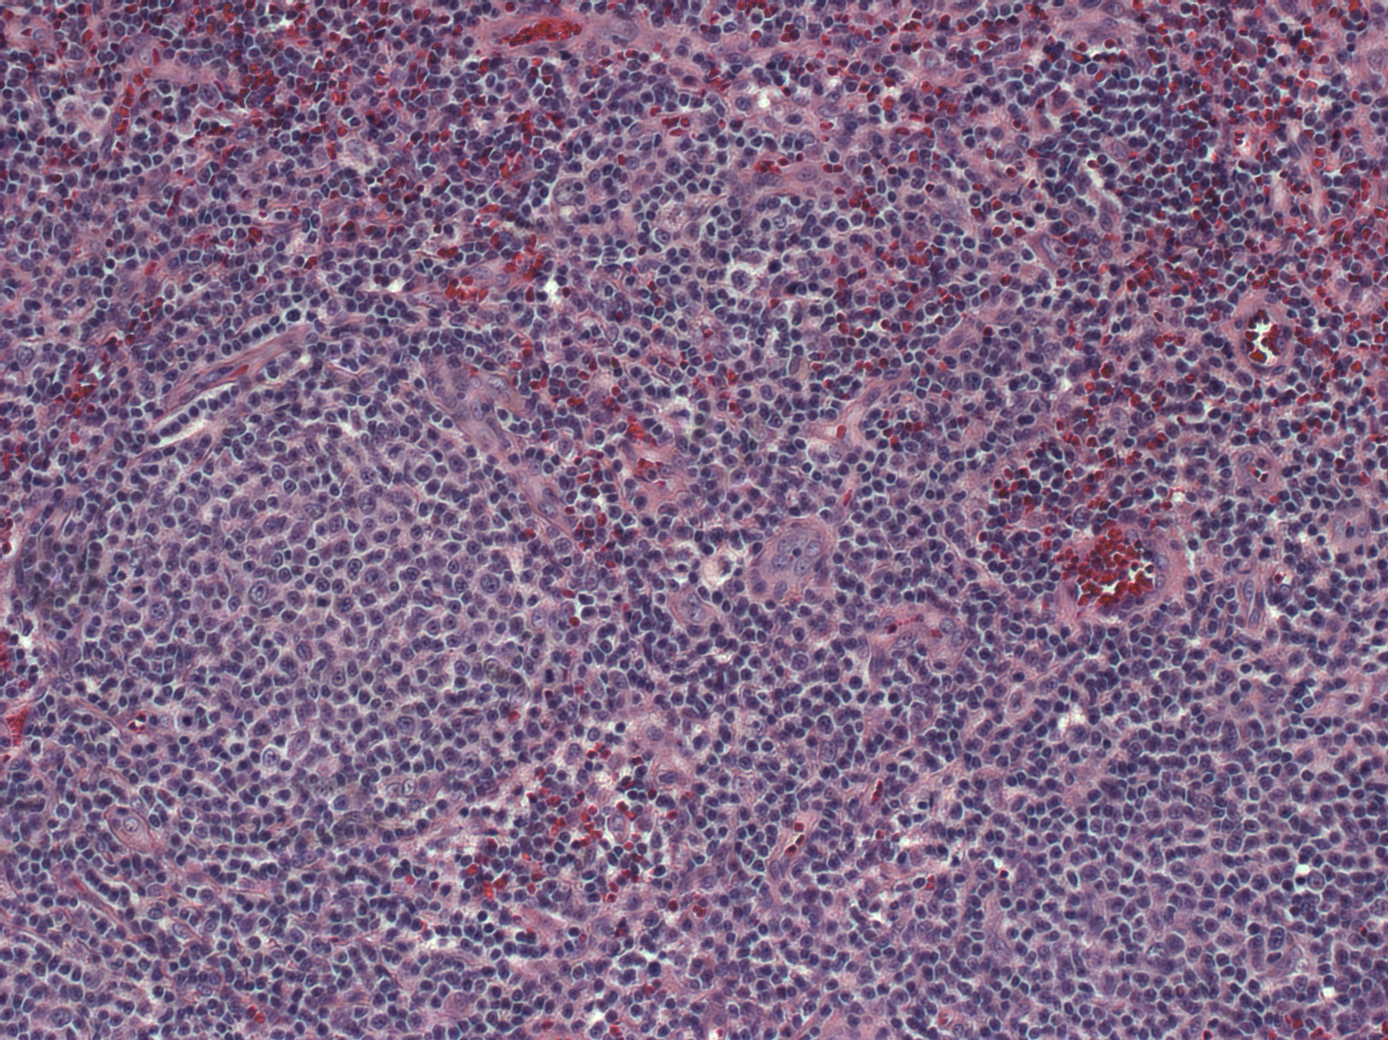

In [7]:
print(f'First entry cancer type: {imgs[0][0]}')
print(f'First entry RGB array: {imgs[0][1]}')
print('First entry image:')
Image.fromarray(imgs[0][1])

###Create DataFrame

In [9]:
df = pd.DataFrame(imgs, columns=['cancer_type', 'img_array'])
df.head(3)

cancer_type                                          img_array
0          FL  [[[172, 140, 155], [177, 140, 158], [168, 123,...
1          FL  [[[208, 173, 188], [212, 173, 202], [176, 122,...
2          FL  [[[110, 68, 99], [112, 68, 105], [102, 63, 108...

# Exploratory Data Analysis

In [10]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [30]:
#@title Default title text
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')# rotation=0?)
            
    autolabel(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(data):

    img_heights = []
    img_widths = []

    # widths and heights if input is pandas series 
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            img = data.iloc[i]
            height, width = img.shape[0], img.shape[1]
            img_heights.append(height)
            img_widths.append(width)

    # widths and heights if input is torchvision dataset
    else:

        for i in range(len(data)):
            width, height = data[i][0].shape[2], data[i][0].shape[1]
            img_heights.append(height)
            img_widths.append(width)

    # cast to set to eliminate duplicates
    img_heights = set(img_heights)
    img_widths = set(img_widths)
        
    print('Image heights are: ', set(img_heights))
    print('Image widths are: ', set(img_widths))

    return img_heights, img_widths

############

def get_intensity_range(data):

    maxs = []
    mins = []

    # intesities if input is pandas series
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            maxs.append(np.amax(data.values[i]))
            mins.append(np.amin(data.values[i]))

    # intensities if input is torchvision dataset
    else:

        for i in range(len(data)):
            maxs.append(torch.max(data[i][0]))
            mins.append(torch.min(data[i][0])) 

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image(data, decode_dict, figsize=(30,10)):

    rand_imgs = []
    rand_idxs = []

    if type(data) is pd.DataFrame:
        for i in range(3):
            data_by_type = data[data['cancer_type']==i]
            rand_img = random.choice(data_by_type['img_array'].values)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[i]}')
            axs[i].imshow(img)

    else:

        i=0
        for i in range(4):
            
            # get random index and store for later
            data_len = len(data)
            data_len = range(data_len)
            rand_idx = random.choice(data_len)
            rand_idxs.append(rand_idx)
            
            # get image with random index and convert RGB array back to image
            rand_img = data[rand_idx][0]
            rand_img = rand_img.permute(1,2,0)
            rand_imgs.append(rand_img)

            i+=1
            if i==4:
                break

        fig, axs = plt.subplots(1, 4, figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[int(data[rand_idxs[i]][1])]}')
            axs[i].imshow(img)

############

def reduce_image_size(series, factor, filter=Image.BICUBIC):

    # Filter can be one of Image.NEAREST, Image.BOX, Image.BILINEAR, 
    # Image.HAMMING, Image.BICUBIC or Image.LANCZOS.
    # Default filter is Image.BICUBIC

    for idx, img in enumerate(series.values):
        (width, height) = (img.width // factor, img.height // factor)
        im = img.resize((width, height), resample=filter)
        series.iloc[idx] = im

###Class distribution

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


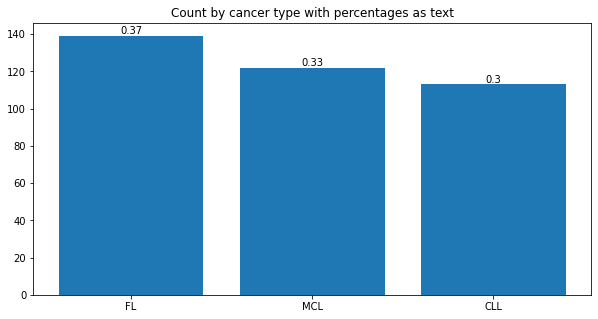

In [12]:
show_value_counts(df['cancer_type'])

###Label Encoding

PyTorch needs the labels to be numerically encoded in order to incorporate them in the dataloader.

In [13]:
encode_dict = {'CLL':0, 'FL':1, 'MCL':2}
decode_dict = {0: 'CLL', 1: 'FL', 2: 'MCL'}
df['cancer_type']=df['cancer_type'].replace(encode_dict)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

In [20]:
img_heights, img_widths = get_image_dims(df['img_array'])

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [22]:
get_intensity_range(df['img_array'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

###Sample images

Let's look at a random image of each cancer type.

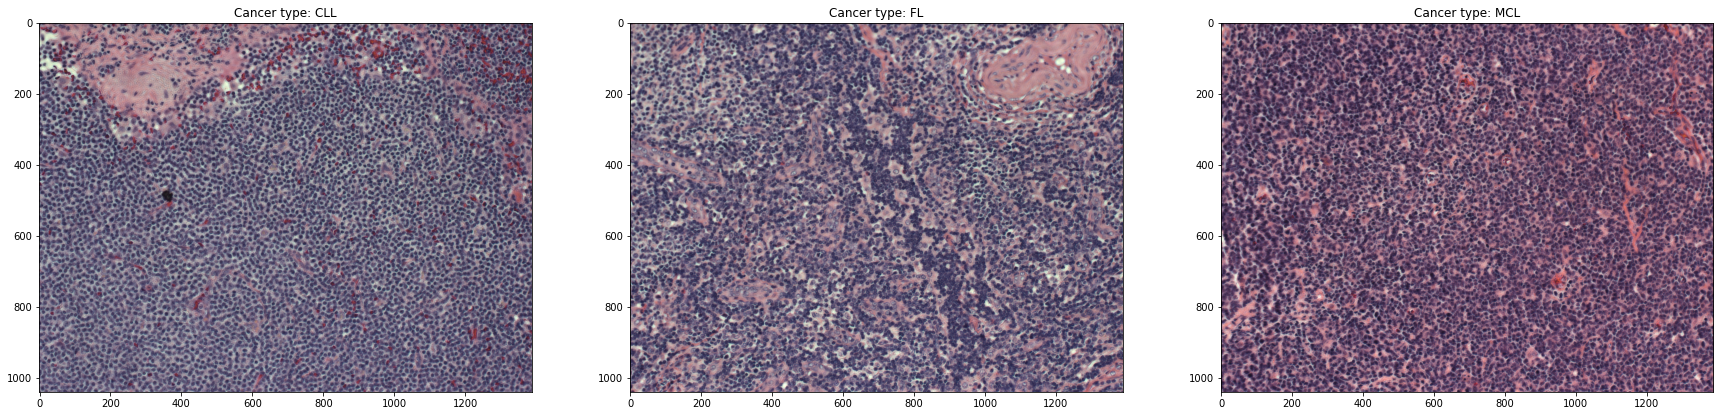

In [31]:
get_random_image(df, decode_dict)

###Image size reduction

In [ ]:
reduce_image_size(df['image'], 4)
img_heights, img_widths = get_image_dims(df['image'])
get_intensity_range(df['image'])

### Define some useful constants for later

In [ ]:
image_height = img_heights.pop()
image_width = img_widths.pop()
image_size = (image_width, image_height)
image_channels = 3

# Prepare Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

###Train test split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [ ]:
print(df_train.shape, df_test.shape)

Store the training and validation data before splitting for later use in normalization transforms

In [ ]:
df_train_and_val = df_train.copy()

###Set visualizing

In [ ]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [ ]:
df_test.head(3)

Let's just reset the index here for clarity.

In [ ]:
df_test.reset_index(inplace=True, drop=True)
df_test.head(3)

In [ ]:
df_test['cancer_type'].value_counts()

###Train val split

The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [ ]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
df_train.head(3)

Again, let's reset our indices.

In [ ]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# Data Generation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

###Device detection

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

###Dataset and dataloader

Albumentations library

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

Define dataset class for dataloader to call

In [ ]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, images, paths, transform=None):
        self.type_ = type_
        self.images = images
        self.paths = paths
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        image = self.images.iloc[idx]
        path = self.paths.iloc[idx]
        label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            image = self.transform(image)

        return (image, label)

############

def define_dataset(type_series, image_series, path_series, transform=None, batch_size=1, shuffle=True, num_workers=2):

    data = lymphoma_images_dataset(type_series, image_series, path_series, transform=transform)
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data, loader


############

def create_data(num_passes, transforms, phase, orig_df):

    new_df = orig_df.copy()
    cols = new_df.columns

    for i in range(num_passes):

        for j in range(len(orig_df)):

            # perform transformations
            new_array = transforms[phase](image=orig_df['rgb_array'].values[j])
            new_array = new_array['image']

            # save transformed data as image
            new_img = Image.fromarray(new_array)

            # normalize and tensorize
            new_array = transforms['normalize_and_tensorize'](image=new_array)
            new_array = new_array['image']

            new_data = {cols[0]:orig_df[cols[0]].iloc[j],
                        cols[1]:new_img,
                        cols[2]:new_array,
                        cols[3]:np.nan}

            new_df = new_df.append(new_data, ignore_index=True)
    
    return new_df


In [ ]:
p = 0.2

tl_means = (0.485, 0.456, 0.406)
tl_stds = (0.229, 0.224, 0.225)

alb_transform_dict = {'train': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'valid': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.RGBShift(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p)
                                          ]),
                      
                      'normalize_and_tensorize': A.Compose([A.Normalize(mean=tl_means, std=tl_stds),
                                                            ToTensorV2()
                                                           ]),
                      
                      'tensorize': A.Compose([ToTensorV2()
                                             ])
                      }


In [ ]:
new_df = create_data(1, alb_transform_dict, 'train', df_train)

In [ ]:
len(new_df)

###Confirm image dimensions and intensities

In [ ]:
img_heights, img_widths = get_image_dims(datasets['train'])

In [ ]:
get_intensity_range(datasets['train'])

###Visualize some generated data

In [ ]:
get_random_image(train_dataset)


# Model Build

In [ ]:
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

###Bespoke model architectures

In [ ]:
class shallow_net(nn.Module):
    # this network will consist of three CRB layers before a fully connected

    def __init__(self):
        super(shallow_net, self).__init__()

        self.conv1_k5 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # initialize weights?? nn.init.kaiming_uniform_, nn.init.xavier_uniform_
        self.ap = nn.AvgPool2d(2)
        self.fc = nn.Linear(1408, 3)

    
    def forward(self, x):
        x = F.relu(self.ap(self.conv1(x)))
        x = x.view(-1)
        x = self.fc(x)
        return F.log_softmax(x)

class medium_net(shallow_net):
     # this network will consist of five CRB layers before a fully connected
    pass

class deep_net(nn.Module):
    # this network will consist of eight CRB layers before a fully connected
    pass

class very_deep_net(nn.Module):
    # this network will consist of twelve CRB layers before a fully connected
    pass

    # def __init__(self, in_channels):
    #     super(Net, self).__init__()

    #     self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

    #     self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

    #     self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    #     self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    #     self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


    # def forward(self, x):

    #     branch1x1 = self.branch1x1(x)

    #     branch5x5 = self.branch5x5_1(x)
    #     branch5x5 = self.branch5x5_2(branch5x5)

    #     branch3x3 = self.branch3x3dbl_1(x)
    #     branch3x3 = self.branch3x3dbl_2(branch3x3)
    #     branch3x3 = self.branch3x3dbl_3(branch3x3)

    #     branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    #     branch_pool = self.branch_pool(branch_pool)

    #     outputs = [branch1x1, branch5x5, branch3x3, branch_pool]

    #     return torch.cat(outputs, 1)




###Transfer learning as feature extractor

Since the dataset being classified is significantly different to the ImageNet data that the transfer learning models have been optimized for, these models will only be used as a feature extractor.  This means that the model parameters will be frozen and the only portion that will be trained are the linear layers at the very end of the network.

In [ ]:
import torchvision.models as models

Going to use three different Resnets and Densenets: a shallow, medium, and deep.  Use four VGG models: two shallow and two deep networks, one with and the other without batch normalization.  Also use Inception v3.

In [ ]:
resnet_models = [models.resnet18(pretrained=True), models.resnet50(pretrained=True), models.resnet152(pretrained=True)]
vgg_models = [models.vgg11(pretrained=True), models.vgg11_bn(pretrained=True), models.vgg19(pretrained=True), models.vgg19_bn(pretrained=True)]
densenet_models = [models.densenet121(pretrained=True), models.densenet161(pretrained=True), models.densenet201(pretrained=True)]
inception = models.inception_v3(pretrained=True)

###Determine the fully connected layers that require replacing

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

################

def replace_fc_layers(models, num_classes):

    if models == resnet_models:
        for model in models:
            # freeze all model parameters
            set_parameter_requires_grad(model, True)

            # replace classification layer
            input_features = model.fc.in_features
            model.fc = nn.Linear(input_features, num_classes)
            model.to(device)

    if models == vgg_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            model.classifier[6] = nn.Linear(4096, num_classes)
            model.to(device)
    
    if models == densenet_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            input_features = model.classifier.in_features
            model.classifier = nn.Linear(input_features, num_classes)
            model.to(device)

    if models == inception:
        set_parameter_requires_grad(models, True)
        models.AuxLogits.fc = nn.Linear(768, num_classes)
        models.fc = nn.Linear(2048, num_classes)
        models.to(device)
    
    return models

Take AlexNet as an example

In [ ]:
print(alexnet)

The last output layer (`alexnet.classifier[6]`) inputs 4096 features and outputs 1000.  We need to replace this with a 4096 to 3 fully connected layer.  This process was repeated for all the networks and stored as the function replace_fc_layers at the top of this section

In [ ]:
print(vgg_models[0])

In [ ]:
num_classes = 3

resnet_models = replace_fc_layers(resnet_models, num_classes)
vgg_models = replace_fc_layers(vgg_models, num_classes)
densenet_models = replace_fc_layers(densenet_models, num_classes)
inception = replace_fc_layers(inception, num_classes)

Run a check to make sure layers were written correctly

In [ ]:
print(f'Resnet18:\n{resnet_models[1].fc}\n\nAlexNet:\n{alexnet.classifier[-3:]}\n')

# Train the Model



In [ ]:
from torch.optim.lr_scheduler import StepLR
import time
import copy

In [ ]:
def training_steps(model, criterion, optimizer, scheduler, epochs=25):    
    start = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*15)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the gradients before training
                optimizer.zero_grad()

                # set gradient calculations ON for training
                with torch.set_grad_enabled(phase == 'train'):
                    if model == inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        
        print()

    time_elapsed = time.time() - start
    print(f'Training time: {time_elapsed // 60}m {time_elapsed % 60}s')
    print()

    model.load_state_dict(best_model_wts)

    return model, val_acc_history


################

def run_training(models, epochs=25):

    val_acc_histories = {}
    
    for model in models:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())
        scheduler = StepLR(optimizer, step_size=5, verbose=True)

        model, val_acc_history = training_steps(model, criterion, optimizer, scheduler, epochs=epochs)
        val_acc_histories[model] = val_acc_history

    return models, val_acc_histories

In [ ]:
trained_models, val_acc_history = run_training([inception], epochs=5)